In [2]:
import os
import pickle
import igraph
import geoplot
import seaborn as sns
from collections import Counter
import numpy as np
import itertools
import pandas as pd
import geopandas as gpd
import mapclassify as mc
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import contextily as ctx
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import matplotlib.colors as colors
import matplotlib.ticker as mtick
from collections import defaultdict
import cartopy
import sys

from statsmodels.nonparametric.kernel_density import *

import GeoDataProcessing.dispatchAnalysis as DA

In [115]:
with open('NYC Graph//NYC_graph_revised.pickle', 'rb') as file:
    graph: igraph.Graph = pickle.load(file)
edges = gpd.read_file('NYC Graph//NYC_edges.geojson')
speeds = pd.read_csv('NYC Graph//edge_speeds_vicky.csv')
speeds = speeds.drop('Unnamed: 0', axis=1)
# Sort the df according to city graph order
speeds.index = speeds['edgeid']
speeds = speeds.loc[graph.es['edgeid'], :]

In [10]:
df = pd.read_excel('dataSummary2Old.xlsx')
df = df.rename(columns={'Optimization Time': 'Optimization Frequency'})
df = df.replace('survivalNoExp', 'Survival Model')
df = df.replace('coverage', 'Coverage Model')
df = df.replace('nearest', 'Nearest')
df = df.replace('preparedness', 'Preparedness')
df['Configuration'] = df['Relocator'] + ' - ' + df['Dispatcher'] # + ' - ' + ['Online' if d else 'Static' for d in df['Online Relocation']]
df['Optimization Frequency'] = ['None' if not d['Online Relocation'] else str(d['Optimization Frequency']) + ' s' for _, d in df.iterrows()]
df[df['Warmup time'] == 0].groupby(['day', 'Relocator', 'Dispatcher', 'Optimization Frequency', 'Is Uber Available', 'UberFractionRevised', 'ALS Tours']).mean()['Replica'].to_excel('Test2.xlsx')

#str((row['day'], row['Relocator'], row['Dispatcher'], row['Online Relocation'], row['Is Uber Available'], row['UberFractionRevised'], row['ALS Tours'], row['Optimization Frequency'], row['Warmup time']

In [146]:
with open('D:/FTP results/friday_0_survivalNoExp_nearest_NoRelocation_Workload_0.2_NoUber_0.05_HRDemand_284ALS642BLS.pickle', 'rb') as f:
    statistics = pickle.load(f)

In [113]:
def extractPathFromRecord(vehicleRecord, city_graph, speeds):

    path = []
    for event in vehicleRecord:
        if event[2] is not None:

            # Compute time period
            timePeriod = 0
            hours = (event[0] % 86400) // 3600
            cummulative_periods = [sum([7, 3, 6, 3, 5][:i+1]) for i in range(len([7, 3, 6, 3, 5]))]
            for i, l in enumerate(cummulative_periods):
                if hours < l:
                    timePeriod = i
                    break

            weights = city_graph.es['length'] / np.array(speeds['p{}n'.format(timePeriod+1)])
            path += graph.get_shortest_paths(event[1], event[2], output='epath', weights=weights)[0]
    return path

In [6]:
def ShpFromPathList(path_list, original_shp):
    return original_shp[original_shp['edgeid'].isin(path_list)]

In [64]:
def getAmbulanceDistribution(ALS, BLS):
    ALS_temporal_factor = [0.17704757309711355, 0.37216567579074344, 0.4507867511121431]
    BLS_temporal_factor = [0.18174623026587763, 0.35084910937050884, 0.4674046603636135]
    borough_demand = np.array([0.23150559, 0.24611048, 0.28303782, 0.19556216, 0.04378395])

    ALS_temporal_distribution = np.trunc(ALS * np.array(ALS_temporal_factor))
    BLS_temporal_distribution = np.trunc(BLS * np.array(BLS_temporal_factor))

    return [[np.round(ALS_temporal_distribution[t]*borough_demand), np.round(BLS_temporal_distribution[t]*borough_demand)] for t in range(len([8,8,8]))]

In [334]:
def shpStreetCount(statistics, ALS, BLS, original_shp, speeds, file_dir):
    distribution = np.cumsum(np.sum(getAmbulanceDistribution(284, 642), axis = 2))
    
    streets = [[],[]]
    if not isinstance(statistics, list):
        for i in range(len(distribution)):
            for j in range(0 if i == 0 else int(distribution[i-1]), int(distribution[i])):
                streets[i%2] += extractPathFromRecord(statistics[1]['Ambulance {}'.format(j)]['Record'], graph, speeds)
    else:
        for s in statistics:
            for i in range(len(distribution)):
                for j in range(0 if i == 0 else int(distribution[i-1]), int(distribution[i])):
                    streets[i%2] += extractPathFromRecord(s[1]['Ambulance {}'.format(j)]['Record'], graph, speeds)

    
    A, B = Counter(graph.es[streets[0]]['edgeid']), Counter(graph.es[streets[1]]['edgeid'])
    
    df = edges.copy(deep=True)
    df.index = df['edgeid']
    df['ALS_count'] = 0
    df['ALS_count'].update(pd.Series(A))
    df['BLS_count'] = 0
    df['BLS_count'].update(pd.Series(B))
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.index = range(len(gdf))

    gdf.to_file(file_dir, driver='GeoJSON')

## Extracting ambulance routes

In [19]:
ShpFromPathList(graph.es[extractPathFromRecord(statistics[1]['Ambulance 15']['Record'], graph)]['edgeid'], edges).to_file('D:/Testing Results/Ambulance 15 NoR.geojson', driver='GeoJSON')

In [31]:
ambulance =268#, 268
for r in [('coverage', 'nearest', 'NoRelocation', ambulance), ('coverage', 'nearest', 'Relocate', ambulance), ('survivalNoExp', 'nearest', 'NoRelocation', ambulance), ('survivalNoExp', 'nearest', 'Relocate', ambulance), ('survivalNoExp', 'preparedness', 'NoRelocation', ambulance), ('survivalNoExp', 'preparedness', 'Relocate', ambulance)]:
    with open('D:/FTP results/friday_0_{}_{}_{}_Workload_0.2_NoUber_0.05_HRDemand_284ALS642BLS.pickle'.format(r[0], r[1], r[2]), 'rb') as f:
        statistics = pickle.load(f)
    ShpFromPathList(graph.es[extractPathFromRecord(statistics[1]['Ambulance ' + str(r[3])]['Record'], graph)]['edgeid'], edges).to_file('D:/Testing Results/Ambulance {} {} {} {}.geojson'.format(r[3], r[0], r[1], r[2]), driver='GeoJSON')

In [153]:
#statistics[1]['Ambulance 903']#['Statistics']['MetersDriven'].data

## Get number of events on each street

In [147]:
shpStreetCount(statistics, 284, 642, edges, speeds)

In [335]:
statisticsObjects = []

dispatchers = ['nearest', 'preparedness']
for r in range(15):
    for dispatcher in dispatchers:
        with open('D:/FTP results/friday_{}_survivalNoExp_{}_Relocate_Workload_0.2_NoUber_0.05_HRDemand_355ALS802BLS.pickle'.format(r,  dispatcher), 'rb') as f:
            statisticsObjects.append(pickle.load(f))

shpStreetCount(statisticsObjects, 355, 802, edges, speeds, 'D:/Testing Results/TotalSurvivalNearestRelocateStreets.geojson')

statisticsObjects = []
for r in range(15):
    for dispatcher in dispatchers:
        with open('D:/FTP results/friday_{}_survivalNoExp_{}_NoRelocation_Workload_0.2_NoUber_0.05_HRDemand_355ALS802BLS.pickle'.format(r,  dispatcher), 'rb') as f:
            statisticsObjects.append(pickle.load(f))

shpStreetCount(statisticsObjects, 355, 802, edges, speeds, 'D:/Testing Results/TotalSurvivalNearestNoRelocationStreets.geojson')

## Histograms

In [336]:
noRelocationStreets = gdf.from_file('D:/Testing Results/TotalSurvivalNearestNoRelocationStreets.geojson')
relocationStreets = gdf.from_file('D:/Testing Results/TotalSurvivalNearestRelocateStreets.geojson')

In [341]:
diff_df = relocationStreets.copy(deep = True)
diff_df['ALS_count'] = diff_df['ALS_count'] - noRelocationStreets['ALS_count']
diff_df['BLS_count'] = diff_df['BLS_count'] - noRelocationStreets['BLS_count']
diff_df.to_file('D:/Testing Results/DiffSurvivalNearestRelocateStreets.geojson', driver='GeoJSON')

(array([5.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 2.0000e+00, 4.0000e+00, 2.1000e+01,
        3.9000e+01, 2.0000e+01, 4.6000e+01, 4.6000e+01, 1.1600e+02,
        3.3600e+02, 5.6600e+02, 2.1130e+03, 6.3964e+04, 8.7750e+03,
        3.2800e+03, 1.5060e+03, 8.8700e+02, 4.5800e+02, 2.1900e+02,
        2.3900e+02, 1.4200e+02, 9.5000e+01, 5.6000e+01, 3.6000e+01,
        6.3000e+01, 4.3000e+01, 2.9000e+01, 2.0000e+01, 3.4000e+01,
        1.0000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00,
        5.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 3.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([-847. , -801.2, -755.4, -709.6, -663.8, -618. , -572.2, -526.4,
        -480.6, -434.8, -389. , -343.2, -297.4, -251.6, -205.8, -160. ,
        -114.2,  -68.4,  -22.6,   23.2,   69. ,  114.8,  160.6,  206.4,
         252.2,  298. ,  343.8,  389.6,  435.4,  481.2,  527. ,  572.8,
         618.6,  664.4,  710.2

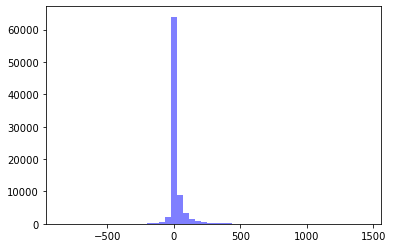

In [340]:
plt.hist(diff_df[diff_df['ALS_count'] != 0 ]['ALS_count'], bins = 50, color='blue', alpha = .5)

(array([6.4168e+04, 8.4550e+03, 4.6580e+03, 2.4920e+03, 1.5490e+03,
        1.0420e+03, 7.0700e+02, 4.7600e+02, 4.1500e+02, 3.4300e+02,
        2.6200e+02, 1.6300e+02, 1.1700e+02, 9.6000e+01, 1.0300e+02,
        9.3000e+01, 6.4000e+01, 4.4000e+01, 4.3000e+01, 5.7000e+01,
        2.9000e+01, 1.0000e+01, 1.6000e+01, 2.0000e+01, 2.1000e+01,
        1.5000e+01, 4.0000e+00, 1.0000e+01, 7.0000e+00, 1.6000e+01,
        7.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00, 6.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([1.00000e+00, 4.57800e+01, 9.05600e+01, 1.35340e+02, 1.80120e+02,
        2.24900e+02, 2.69680e+02, 3.14460e+02, 3.59240e+02, 4.04020e+02,
        4.48800e+02, 4.93580e+02, 5.38360e+02, 5.83140e+02, 6.27920e+02,
        6.72700e+02, 7.17480e+02, 7.62260e+02, 8.07040e+02, 8.51820e+02,
        8.96600e+02, 9.413

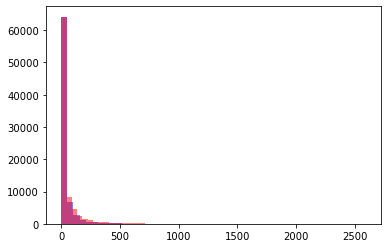

In [337]:
plt.hist(noRelocationStreets[noRelocationStreets['ALS_count'] > 0]['ALS_count'], bins = 50, color='blue', alpha = .5)
plt.hist(relocationStreets[relocationStreets['ALS_count'] > 0]['ALS_count'], bins = 50, color='red', alpha = .5)

# Box plots

In [98]:
df = pd.read_excel('dataSummary3.xlsx')

availability = {355: 1, 337: .95, 319: .9, 301: .85, 284: .8}

df = df.rename(columns={'Optimization Time': 'Optimization Frequency'})
df = df.replace('survivalNoExp', 'Survival Model')
df = df.replace('coverage', 'Coverage Model')
df = df.replace('nearest', 'Nearest')
df = df.replace('preparedness', 'Preparedness')
df['Configuration'] = df['Relocator'] + ' - ' + df['Dispatcher'] # + ' - ' + ['Online' if d else 'Static' for d in df['Online Relocation']]
df['Optimization Frequency'] = ['None' if not d['Online Relocation'] else str(d['Optimization Frequency']) + ' s' for _, d in df.iterrows()]
df['Ambulance Availability'] = [availability[d['ALS Tours']] for _, d in df.iterrows()]

uberAvailable = False
onlineRelocation = True

df = df[(df['Optimization Frequency'] == '300 s') & (df['Is Uber Available'] == uberAvailable) & (df['day'] == 'friday')]

data = defaultdict(list)
for av in [.8, .85, .9, .95, 1]:
    for r in range(15):
        ES_SurPrep = float(df[(df['Configuration'] == 'Survival Model - Preparedness') & (df['Ambulance Availability'] == av) & (df['Replica'] == r)]['Expected Survivors HS'])
        data['Survival - Preparedness - {}'.format(av)].append(ES_SurPrep)

        ES_CovNear = float(df[(df['Configuration'] == 'Coverage Model - Nearest') & (df['Ambulance Availability'] == av) & (df['Replica'] == r)]['Expected Survivors HS'])
        data['Coverage - Nearest - {}'.format(av)].append(ES_CovNear)
        
        ES_CovPrep = float(df[(df['Configuration'] == 'Coverage Model - Preparedness') & (df['Ambulance Availability'] == av) & (df['Replica'] == r)]['Expected Survivors HS'])
        data['Coverage - Preparedness - {}'.format(av)].append(ES_CovPrep)
        
        ES_SurNear = float(df[(df['Configuration'] == 'Survival Model - Nearest') & (df['Ambulance Availability'] == av) & (df['Replica'] == r)]['Expected Survivors HS'])
        data['Survival - Nearest - {}'.format(av)].append(ES_SurNear)

### t Test

In [257]:
configs = [c + ' - ' + str(av) for av in [.8, .85, .9, .95, 1] for c in ['Survival - Preparedness', 'Coverage - Preparedness', 'Survival - Nearest', 'Coverage - Nearest']]
ES_df = pd.DataFrame.from_dict(data)

t_alpha_results = []
t_interval_results = []
for c1 in configs:
    t_alpha_c1_results = []
    t_interval_c1_results = []
    for c2 in configs:
        if c1 != c2:
            t_alpha_c1_results.append(stats.ttest_ind(ES_df[c1], ES_df[c2])[1])
            t_interval_c1_results.append('[' + str(stats.ttest_ind(ES_df[c1], ES_df[c2])[0] - 2.145) + ', ' + str(stats.ttest_ind(ES_df[c1], ES_df[c2])[0] + 2.145) + ']')
        else:
            t_alpha_c1_results.append('-')
            t_interval_c1_results.append('-')
    t_alpha_results.append(t_alpha_c1_results)
    t_interval_results.append(t_interval_c1_results)

t_test_alpha = pd.DataFrame.from_dict(t_alpha_results)
t_test_alpha.columns = configs
t_test_alpha.index = configs
t_test_alpha.to_excel('Analysis Statistics/t Test alpha values.xlsx')

t_test_intervals = pd.DataFrame.from_dict(t_interval_results)
t_test_intervals.columns = configs
t_test_intervals.index = configs
t_test_intervals.to_excel('Analysis Statistics/t Test intervals.xlsx')

### Tukey's test

In [100]:
configs = [c + ' - ' + str(av) for av in [.8, .85, .9, .95, 1] for c in ['Survival - Preparedness', 'Coverage - Preparedness', 'Survival - Nearest', 'Coverage - Nearest']]
ES_df = pd.DataFrame.from_dict(data)

df = pd.DataFrame()
for c in configs:
    df[c] = ES_df[c]

# Stack the data (and rename columns):

stacked_data = df.stack().reset_index()
stacked_data = stacked_data.rename(columns={'level_0': 'id',
                                            'level_1': 'treatment',
                                            0:'result'})
MultiComp = MultiComparison(stacked_data['result'],
                            stacked_data['treatment'])
#tukey_plot = MultiComp.tukeyhsd().plot_simultaneous()#.summary()
#MultiComp.tukeyhsd().summary()

## Comparison

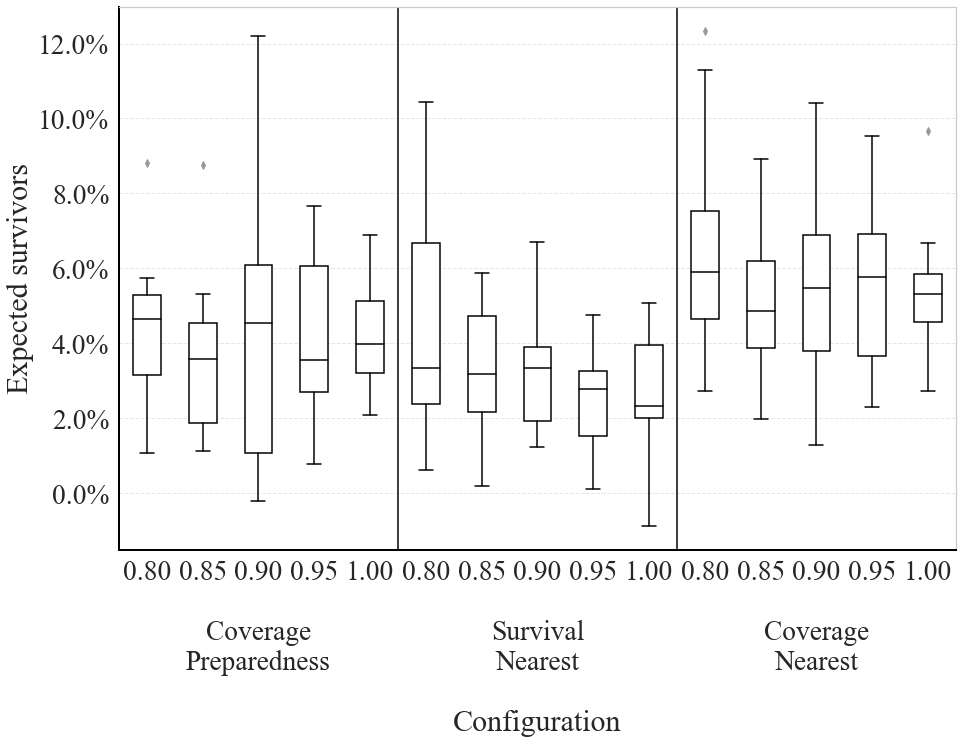

In [101]:
fig, axs = plt.subplots(1,1, figsize=(15,10))
sns.set_theme(style="whitegrid", font_scale = 2.5, font='Times New Roman')

diff_df = pd.DataFrame.from_dict(data)
configs = [c + ' - ' + str(av) for c in ['Coverage - Preparedness', 'Survival - Nearest', 'Coverage - Nearest'] for av in [.8, .85, .9, .95, 1]]
for c in configs:
    diff_df[c] = (diff_df['Survival - Preparedness - {}'.format(c[c.rfind('-')+1:].strip())] - diff_df[c])*100/diff_df[c]

diff_df = diff_df[configs]

sns.boxplot(data=diff_df, ax = axs, width=.5, color = "w")

# iterate over boxes
for i,box in enumerate(axs.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         axs.lines[j].set_color('black')

axs.spines['left'].set_linewidth(2)
axs.spines['left'].set_color('black')
axs.spines['bottom'].set_linewidth(2)
axs.spines['bottom'].set_color('black')
axs.grid(axis = 'y', linestyle='--', alpha= .5)
axs.yaxis.set_major_formatter(mtick.PercentFormatter())
axs.set_ylabel('Expected survivors')
axs.set_xlabel('Configuration')
#plt.xticks(rotation=90)

width = 4
x = list()
for i in range(3):
    x.extend([5*i, 5*i + 1, 5*i+2, 5*i+3, 5*i+4, 5*i+width/2. + 1e-6])
x.extend([0.01])

axs.set_xticks(x)
axs.set_xticklabels(('0.80', '0.85', '0.90', '0.95', '1.00', '\n\nCoverage\nPreparedness', '0.80', '0.85', '0.90', '0.95', '1.00', '\n\nSurvival\nNearest', '0.80', '0.85', '0.90', '0.95', '1.00', '\n\nCoverage\nNearest', '\n\n\n\n'),ha='center')
plt.axline((4.5,0), (4.5, 12), color='black')
plt.axline((9.5,0), (9.5, 12), color='black')
fig.savefig('replicaComparisons5min.pdf', bbox_inches = 'tight', pad_inches = 0)
#axs.xaxis.set_major_locator(mtick.MultipleLocator(5))

<AxesSubplot:>

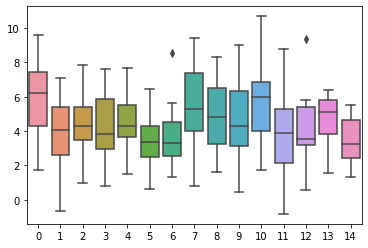

In [204]:
sns.boxplot(data=df.from_dict(data).T, )

In [219]:
t = (df.from_dict(data).T.mean(axis=1))*(15**.5)/df.from_dict(data).T.std(axis=1)
t_df = pd.DataFrame([t - 2.145, t + 2.145]).T
t_df.columns = ['LB', 'UB']
t_df

,LB,UB
Coverage - Nearest - 0.8,7.813976,12.103976
Coverage - Preparedness - 0.8,5.582455,9.872455
Survival - Nearest - 0.8,4.785422,9.075422
Coverage - Nearest - 0.85,7.161233,11.451233
Coverage - Preparedness - 0.85,4.724627,9.014627
Survival - Nearest - 0.85,6.468072,10.758072
Coverage - Nearest - 0.9,11.576086,15.866086
Coverage - Preparedness - 0.9,5.723813,10.013813
Survival - Nearest - 0.9,6.492988,10.782988
Coverage - Nearest - 0.95,8.075275,12.365275


In [255]:
stats.ttest_ind(ES_df['Survival - Preparedness - 1'], ES_df['Coverage - Nearest - 1'])

Ttest_indResult(statistic=5.6626458823847905, pvalue=4.553563839449817e-06)

# Response time box plots

In [286]:
relocators = ['coverage', 'survivalNoExp']
dispatchers = ['nearest', 'preparedness']

HS_responseTimes = defaultdict(list)
for r in range(15):
    for relocator in relocators:
        for dispatcher in dispatchers:
            with open('D:/FTP results/friday_{}_{}_{}_Relocate_Workload_0.2_NoUber_0.05_HRDemand_355ALS802BLS.pickle'.format(r, relocator, dispatcher), 'rb') as f:
                statistics = pickle.load(f)
            HS_responseTimes[relocator + ' - ' + dispatcher] += [d[1] for d in statistics[0]['HSresponseTime'].data]
for k in HS_responseTimes.keys():
    HS_responseTimes[k] = HS_responseTimes[k][:22510]

<AxesSubplot:>

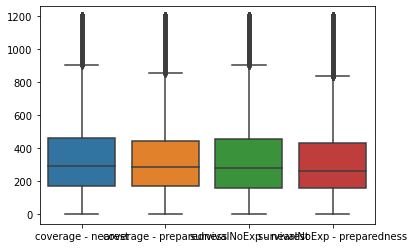

In [306]:
sns.boxplot(data=pd.DataFrame.from_dict(HS_responseTimes).clip(0,1200))

In [307]:
pd.DataFrame.from_dict(HS_responseTimes).mean()


coverage - nearest              354.497127
coverage - preparedness         342.051839
survivalNoExp - nearest         356.903735
survivalNoExp - preparedness    337.529968
dtype: float64

# Geographical Response times

In [69]:
def mapGraphNodesDataToUniformDemand(data, demand_nodes, city_nodes_df, agg='sum', default=1, value_col='value'):
    """
    With an iterable of tuples (pos, value), return a geodataframe with geometry of uniform demand nodes
    and aggregated values
    """
    data_dict = defaultdict(list)
    for d in data:
        data_dict[d[0]].append(d[1])
    data_list = [(k, v) for k, v in data_dict.items()]
    positions = [d[0] for d in data_list]
    
    new_df = demand_nodes.copy()
    new_df[value_col] = default
    
    city_nodes_df.index = city_nodes_df['osmid']

    nearest_indexes = DA.nearest_neighbor(city_nodes_df.loc[positions,:], demand_nodes, index = True)[0]

    demand_dict = defaultdict(list)
    for i, index in enumerate(nearest_indexes):
        demand_dict[index] += data_list[i][1]
    demand_list = [(k, v) for k, v in demand_dict.items()]
    positions = [d[0] for d in demand_list]
    
    new_df.index = range(len(new_df))

    if agg == 'sum':
        new_df.loc[positions, value_col] = [np.sum(d[1]) for d in demand_list]
    elif agg == 'avg':
        new_df.loc[positions, value_col] = [np.mean(d[1]) for d in demand_list]
    elif agg == 'min':
        new_df.loc[positions, value_col] = [np.min(d[1]) for d in demand_list]
    elif agg == 'max':
        new_df.loc[positions, value_col] = [np.max(d[1]) for d in demand_list]
    else:
        raise ValueError('Aggregate type not understood')

    return new_df

In [66]:
DATA_DIR = 'C:/Users/Yamil/Proyectos/Proyectos en Git/Memoria Ambulancias/'
nyc_boundaries = gpd.read_file(DATA_DIR + 'Old Files/Generated Shapefiles/NYC Subdivisions/Borough Boundaries/Borough Boundaries.shp')
demand_points = gpd.read_file(DATA_DIR + 'Old Files/Generated Shapefiles/GeoTools/Uniform600m/Uniform600mDemand.geojson')
candidate_points = gpd.read_file(DATA_DIR + 'ems-ny-data/NYC Graph/EMScandidatesMixedLR.geojson')
nyc_graph_nodes = gpd.read_file(DATA_DIR + 'ems-ny-data/NYC Graph/NYC_nodes_revised.geojson')

In [67]:
time_periods = np.cumsum([7, 3, 6, 3, 5])

HS_responseSpatialSurvivalPreparedness= defaultdict(list)
HS_responseSpatialCoverageNearest = defaultdict(list)

for r in range(15):
    with open('D:/FTP results/friday_{}_survivalNoExp_preparedness_Relocate_Workload_0.2_NoUber_0.05_HRDemand_355ALS802BLS.pickle'.format(r), 'rb') as f:
        statistics = pickle.load(f)
    
    df = pd.DataFrame(statistics[0]['SpatialHSAverageResponseTime'].data, columns = ['time', 'node', 'responseTime'])
    
    for i, t in enumerate(time_periods):
        if i == 0:
            sub_df = df[df['time'] < t*3600]
        else:
            sub_df = df[(df['time'] < t*3600) & (df['time'] > time_periods[i-1]*3600)]
        HS_responseSpatialSurvivalPreparedness[i] += list(zip(sub_df['node'], sub_df['responseTime']))
    
    # Coverage nearest
    with open('D:/FTP results/friday_{}_coverage_nearest_Relocate_Workload_0.2_NoUber_0.05_HRDemand_355ALS802BLS.pickle'.format(r), 'rb') as f:
        statistics = pickle.load(f)
    
    df = pd.DataFrame(statistics[0]['SpatialHSAverageResponseTime'].data, columns = ['time', 'node', 'responseTime'])
    
    for i, t in enumerate(time_periods):
        if i == 0:
            sub_df = df[df['time'] < time_periods[i]*3600]
        else:
            sub_df = df[(df['time'] < time_periods[i]*3600) & (df['time'] > time_periods[i-1]*3600)]
        
        HS_responseSpatialCoverageNearest[i] += list(zip(sub_df['node'], sub_df['responseTime']))
    

In [392]:
for t in range(5):
    mapGraphNodesDataToUniformDemand(HS_responseSpatialSurvivalPreparedness[t], demand_points, nyc_graph_nodes, agg='avg', default=0).to_file('D:/Testing Results/responseTimeSurvivalPreparedness{}.geojson'.format(t), driver='GeoJSON')
    mapGraphNodesDataToUniformDemand(HS_responseSpatialCoverageNearest[t], demand_points, nyc_graph_nodes, agg='avg', default=0).to_file('D:/Testing Results/responseTimeCoverageNearest{}.geojson'.format(t), driver='GeoJSON')

In [70]:
for t in range(5):

    survival = mapGraphNodesDataToUniformDemand(HS_responseSpatialSurvivalPreparedness[t], demand_points, nyc_graph_nodes, agg='avg', default=0)
    coverage = mapGraphNodesDataToUniformDemand(HS_responseSpatialCoverageNearest[t], demand_points, nyc_graph_nodes, agg='avg', default=0)

    difference = survival.copy(deep=True)
    difference['value'] = survival['value'] - coverage['value']
    difference.to_file('D:/Testing Results/responseTimeDifference{}.geojson'.format(t), driver='GeoJSON')

# Read from file

## Loading a necessary shp

In [128]:
DATA_DIR = ''
nodes_with_borough = gpd.read_file(DATA_DIR + 'NYC Graph//NYC_nodes_w_borough//NYC_nodes_w_borough.shp')

In [276]:
def SurvivalFunction(response_times):
        return (1 + np.exp(0.679 + .262 * response_times)) ** -1

def extractStatisticsByFile(file_name):

    with open('{}'.format(file_name), 'rb') as f:
        statistics = pickle.load(f)

    expected_survivors = sum([SurvivalFunction(d[1]/60) for d in statistics[0]['HSresponseTime'].data])
    total_meters_driven = sum([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] for v in statistics[1].keys()])
    mean_meters_driven = np.mean([statistics[1][v]['Statistics']['MetersDriven'].data[-1][1] for v in statistics[1].keys()])

    total_ambulance_time = 0
    total_state_0_time = 0
    total_state_1_time = 0
    total_state_2_time = 0

    for v in statistics[1].keys():
        if statistics[1][v]['Statistics']['State'].data[-1][0] < 3600*8:
            total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0]
        else:
            total_ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0]
        
        vehicle_state_1_time = 0
        vehicle_state_2_time = 0
        for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
            if d[1] == 1:
                vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
            elif d[1] == 2:
                vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
        
        if(len(statistics[1][v]['Statistics']['State'].data) > 1):
            total_state_0_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0] - vehicle_state_1_time - vehicle_state_2_time
            total_state_1_time += vehicle_state_1_time
            total_state_2_time += vehicle_state_2_time
    
    server_utilization = [total_state_0_time/(total_state_0_time + total_state_1_time + total_state_2_time), total_state_1_time/(total_state_0_time + total_state_1_time + total_state_2_time), total_state_2_time/(total_state_0_time + total_state_1_time + total_state_2_time)]

    responseLSNoUber = []
    for e in statistics[2]:
        if not e[-1] and e[2] > 1:
            responseLSNoUber.append(e[4] - e[3])


    substring = file_name
    day = substring[substring.rindex('/')+1:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    model = substring[:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    replica = int(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    relocate = True if substring[:substring.index('_')] == 'Online' else False
    substring = substring[substring.index('_')+1:]
    workload_limit = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    gap = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    parameters_dir = substring[:substring.index('_')]
    substring = substring[substring.index('_')+1:]
    ALSTours = int(substring[:substring.index('ALS')])
    substring = substring[substring.index('ALS')+3:]
    BLSTours = int(substring[:substring.index('BLS')])
    substring = substring[substring.index('BLS')+4:]
    simTime = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    uberHours = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    maxRelocations = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    uncoveredPenalty = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    lateResponse = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    dispatchingPenalty = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    traveltimePenalty = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    relocationTarget = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    maxRelocationTime = float(substring[:substring.index('_')])
    substring = substring[substring.index('_')+1:]
    relocationCooldown = float(substring[:substring.index('.')])

    return [day, model, replica, relocate, workload_limit, gap, parameters_dir, ALSTours, BLSTours, simTime, uberHours, maxRelocations, uncoveredPenalty, lateResponse, dispatchingPenalty,
            traveltimePenalty, relocationTarget, maxRelocationTime, relocationCooldown,
            statistics[0]['EmergenciesServed'].data,statistics[0]['EmergenciesTimeInSystem'].average(), statistics[0]['HSresponseTime'].average(),
            statistics[0]['LSresponseTime'].average(), np.mean(responseLSNoUber),statistics[0]['PercentageALSlt10min'].data[-1][1], statistics[0]['PercentageALSlt8min'].data[-1][1],                statistics[0]['PercentageALSlt7min'].data[-1][1], len(statistics[0]['UberCalls'].data), statistics[0]['UberResponseTime'].average(), expected_survivors, statistics[0]                   ['EmergenciesWaiting'].average(), mean_meters_driven, total_meters_driven, server_utilization[0], server_utilization[1], server_utilization[2]]

In [278]:
DIR = 'D:/FTP results/New Model/'
data = []
elementos = []
for r,d,f in os.walk('D:/FTP results/New Model/'):
    for file in f:
        if '.pickle' in file:
            data.append(extractStatisticsByFile('D:/FTP results/New Model/' + file))
df = pd.DataFrame(data, columns=['Day', 'Model', 'Replica', 'Online Relocation', 'Workload Limit', 'GAP', 'Parameters Config', 'ALS Tours', 'BLSTours', 'Simulation Time', 'Uber Hours', 'Max Relocations', 'Uncovered Penalty', 'Late Response Penalty', 'Dispatching Penalty', 'Travel Time Penalty', 'Relocation Target', 'Max Relocation Travel Time', 'Relocation Cooldown', 'Emergencies Served' 'Emergencies TIS', 'Mean HS response time', 'Mean LS response time', 'Mean LS response time No Uber','Percentage ALS < 10min','Percentage ALS < 8min','Percentage ALS < 7min', 'Uber Calls', 'Uber Response Time', 'Expected Survivors HS','Average emergencies waiting', 'Mean Meters Driven', 'Total Meters Driven', 'Server Utilization Idle', 'Server Utilization Relocating', 'Server Utilization Attending'])
df.to_excel('Maps and Others/dataSummaryTest01.xlsx')

ValueError: 35 columns passed, passed data had 36 columns

In [283]:
df.to_excel('Maps and Others/dataSummaryTest01.xlsx')

In [145]:
with open('test03.pickle', 'rb') as f:
    statistics = pickle.load(f)

In [97]:
statistics[1]['Ambulance 350']['Record']

[(0, '42427979', '42427979', None, None),
 (30896.418527907503, '42427979', '596776165', None, None),
 (31735.597440897192, '596776165', '42428438', None, None),
 (31752.83114781487, '596776165', None, None, None),
 (31752.83114781487, '596776165', '42428438', None, None),
 (31765.454803101587, '42457660', None, None, None),
 (31765.454803101587, '42457660', '42428438', None, None),
 (31769.0, '42457660', None, None, None),
 (31769.0, '42457660', '42428438', None, None),
 (31769.80874624691, '42457660', None, None, None),
 (31769.80874624691, '42457660', '42428438', None, None),
 (32408.744313764197, '42428438', '42432736', None, None),
 (34122.0,
  '4205830392',
  '42433035',
  None),
 (35186.02124981594, '42433035', '42432736', None, None),
 (37264.86816569782, '42432736', '4163883691', None, None),
 (37412.3490450005, '42424439', None, None, None),
 (37412.3490450005, '42424439', '4163883691', None, None),
 (37426.30077619722, '7106607090', None, None, None),
 (37426.30077619722, '7

In [125]:
statistics[1]['Ambulance 205']['Record']#['Statistics']['State'].data

[(0, '4202436850', '4202436850', None, None),
 (0, '4444865500', '4444865500', None, None),
 (15512.0, '4444865500', '42985910', None, None)]

In [146]:
utilization = defaultdict(list)
for v in statistics[1].keys():
    ambulance_time = statistics[1][v]['Statistics']['TimeInSystem'].data
    if ambulance_time == 0:
        continue
        ambulance_time += statistics[1][v]['Statistics']['State'].data[-1][0] - statistics[1][v]['Statistics']['State'].data[1][0]
    borough = int(nodes_with_borough[nodes_with_borough['osmid'] == statistics[1][v]['Record'][1][1]]['boro_code'])
    vehicle_state_1_time = 0
    vehicle_state_2_time = 0
    for i, d in enumerate(statistics[1][v]['Statistics']['State'].data[:-1]):
        if d[1] == 1:
            vehicle_state_1_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
        elif d[1] == 2:
            vehicle_state_2_time += statistics[1][v]['Statistics']['State'].data[i+1][0] - d[0]
    
    #print(v, ambulance_time, vehicle_state_1_time, vehicle_state_2_time)
    server_utilization = [v, (ambulance_time - vehicle_state_1_time - vehicle_state_2_time)/ambulance_time, vehicle_state_1_time/ambulance_time, vehicle_state_2_time/ambulance_time]
    utilization[borough].append(server_utilization)

In [131]:
utilization

defaultdict(list, {1: []})

<AxesSubplot:xlabel='Idle'>

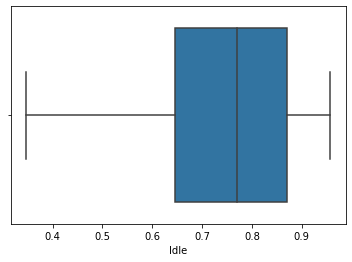

In [152]:
df = pd.DataFrame(utilization[2], columns = ['id','Idle', 'Reloc', 'Att']).sort_values('Idle')
sns.boxplot(df['Idle'])

In [121]:
df.sort_values('Idle')

,id,Idle,Reloc,Att
186,Ambulance 34,0.229988,0.204222,0.565790
12,Ambulance 49,0.345344,0.175419,0.479237
13,Ambulance 36,0.351149,0.151945,0.496907
32,Ambulance 50,0.359038,0.222113,0.418849
195,Ambulance 37,0.370389,0.106050,0.523562
...,...,...,...,...
57,Ambulance 204,0.964266,0.035734,0.000000
117,Ambulance 202,0.968681,0.031319,0.000000
131,Ambulance 203,0.975341,0.024659,0.000000
129,Ambulance 205,0.980389,0.019611,0.000000


In [151]:
def SurvivalFunction(response_times):
        return (1 + np.exp(0.679 + .262 * response_times)) ** -1
sum([SurvivalFunction(d[1]/60) for d in statistics[0]['HSresponseTime'].data])

53.042756382657366

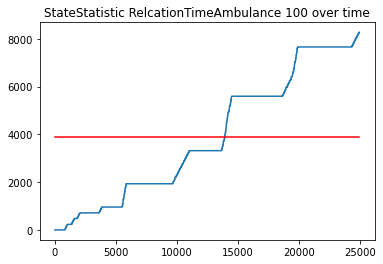

[(0, '278212844', '278212844', None, None),
 (0, '42734590', '42734590', None, None),
 (818.5674979010014, '42734590', '42739371', None, None),
 (1364.2968529238697, '42739371', '42734590', None, None),
 (1831.0, '42734590', '42739371', None, None),
 (3616.0, '42739371', '42734590', None, None),
 (5494.154431284141, '42734590', '42737140', None, None),
 (5500.168280177959, '42734590', None, None, None),
 (5500.168280177959, '42734590', '42737140', None, None),
 (5518.653039539079, '42734590', None, None, None),
 (5518.653039539079, '42734590', '42737140', None, None),
 (5528.05914797262, '42745599', None, None, None),
 (5528.05914797262, '42745599', '42734590', None, None),
 (5528.06959744602, '42745599', None, None, None),
 (5528.06959744602, '42745599', '42737140', None, None),
 (9634.99501535496, '254683643', '42745085', None, None),
 (13633.323422967667, '42745085', '42747983', None, None),
 (13637.918776505556, '42745085', None, None, None),
 (13637.918776505556, '42745085', '4274

In [263]:
statistics[1]['Ambulance 100']['Statistics']['RelocationTime'].visualize()
statistics[1]['Ambulance 100']['Record']

In [242]:
DATA_DIR = ''

with open(DATA_DIR + 'NYC Graph//NYC_graph_revised.pickle', 'rb') as file:
    graph: igraph.Graph = pickle.load(file)
# Load the speeds df
speeds = pd.read_csv(DATA_DIR + 'NYC Graph//edge_speeds_vicky.csv')
speeds = speeds.drop('Unnamed: 0', axis=1)

# Sort the df according to city graph order
speeds.index = speeds['edgeid']
speeds = speeds.loc[graph.es['edgeid'], :]

In [255]:
graph.shortest_paths('42985910', '4444865500', weights = graph.es['length'] / np.array(speeds['p2n']))

[[436.4243959161176]]